# Classification of what activity a person is engaged in: walking, standing, running or climbing stairs according to accelerometer data from a mobile phone

### Import of necessary packages

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Data loading and visualization

In [2]:
folder_path = 'data_hw_5'

# List to store data
data = []

# Get a list of folders and files
for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        # Read the data from the CSV file and add it to the data list
        df_csv = pd.read_csv(file_path)
        df_csv['activity'] = os.path.basename(root)
        df_csv['number'] = re.search(r'-(\d+)\.', file).group(1)
        data.append(df_csv)

# Combine all data into one DataFrame
df = pd.concat(data, ignore_index=True)

# Display the DataFrame
df

,accelerometer_X,accelerometer_Y,accelerometer_Z,activity,number
0,1.000776,4.616021,8.576031,idle,1
1,0.718261,4.209007,8.446744,idle,1
2,-0.909797,-0.282516,9.203311,idle,1
3,5.099650,0.148441,8.418014,idle,1
4,1.762132,-0.162806,9.251195,idle,1
...,...,...,...,...,...
193855,5.109226,-15.452178,-1.470040,walking,999
193856,6.373365,-11.741165,-8.226476,walking,999
193857,3.289633,-9.993398,-0.383072,walking,999
193858,-2.978387,-3.050213,1.273715,walking,999


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193860 entries, 0 to 193859
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   accelerometer_X  193860 non-null  float64
 1   accelerometer_Y  193860 non-null  float64
 2   accelerometer_Z  193860 non-null  float64
 3   activity         193860 non-null  object 
 4   number           193860 non-null  object 
dtypes: float64(3), object(2)
memory usage: 7.4+ MB


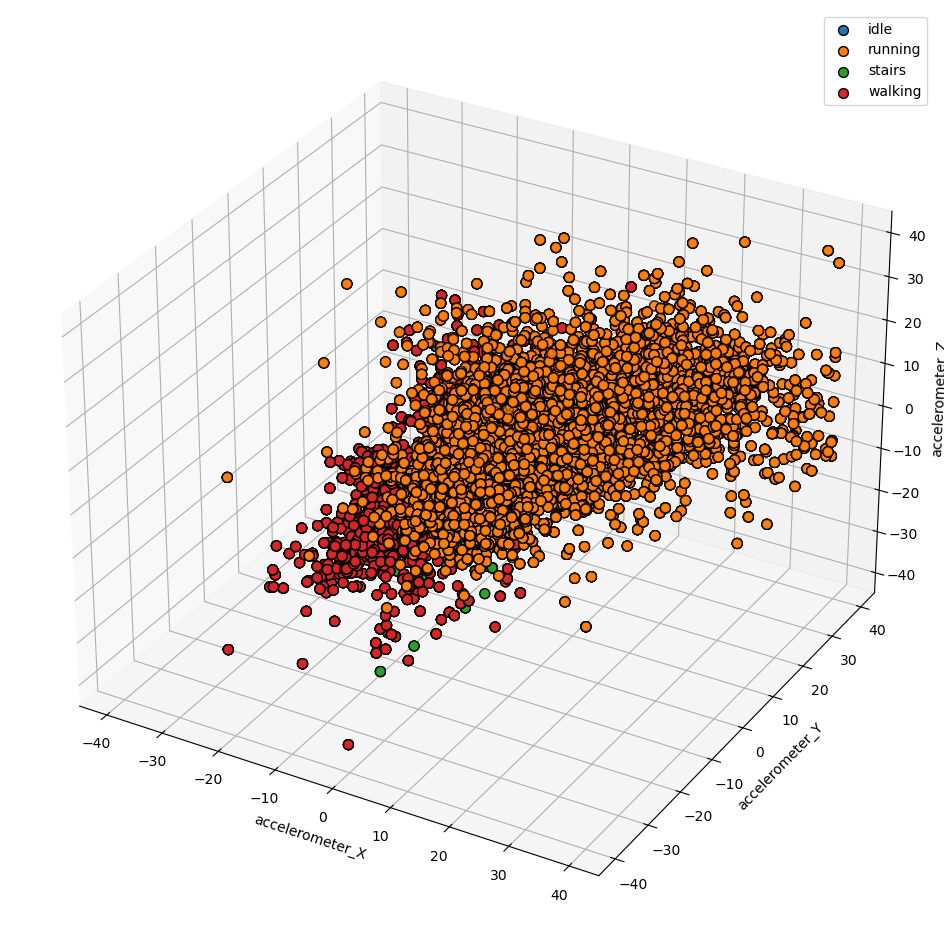

In [12]:
# Build a 3D diagram for accelerometer_X , accelerometer_Y ,accelerometer_Z features by activity

fig = plt.figure(figsize=(15, 12))

ax = fig.add_subplot(111, projection='3d')

x = df['accelerometer_X']
y = df['accelerometer_Y']
z = df['accelerometer_Z']
target = df['activity']

# Divide the data by activities and plot a graph for each category
for activity in np.unique(target):
    ax.scatter(x[target == activity], 
               y[target == activity], 
               z[target == activity], 
               label=activity, edgecolors='black', s=50)

ax.set_xlabel('accelerometer_X')
ax.set_ylabel('accelerometer_Y')
ax.set_zlabel('accelerometer_Z')
ax.legend()

plt.show()

### SVC Model without time domain features

In [3]:
# Preparation data for model
X = df[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']]
y = df['activity']

# Creating training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Model initialization
svm_model = SVC(kernel='rbf')

# Model training
svm_model.fit(X_train, y_train)

In [10]:
# Evaluation of the model on test data
y_pred = svm_model.predict(X_test)

print("Accuracy:")
print(accuracy_score(y_test, y_pred))

print("Classification report:")
print(classification_report(y_test, y_pred))

Accuracy:
0.8920612813370473
Classification report:
              precision    recall  f1-score   support

        idle       0.95      0.99      0.97      6203
     running       0.93      0.90      0.92     20485
      stairs       1.00      0.00      0.00      1022
     walking       0.80      0.90      0.85     11062

    accuracy                           0.89     38772
   macro avg       0.92      0.70      0.68     38772
weighted avg       0.90      0.89      0.88     38772



### RandomForest Model without time domain features

In [16]:
# Model initialization
rf_model = RandomForestClassifier(random_state=42, n_estimators=120)

# Model training
rf_model.fit(X_train, y_train)

# Evaluation of the model on test data
y_pred = rf_model.predict(X_test)

print("Accuracy:")
print(accuracy_score(y_test, y_pred))

print("Classification report:")
print(classification_report(y_test, y_pred))

Accuracy:
0.9995873310636542
Classification report:
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00      6203
     running       1.00      1.00      1.00     20485
      stairs       1.00      0.99      0.99      1022
     walking       1.00      1.00      1.00     11062

    accuracy                           1.00     38772
   macro avg       1.00      1.00      1.00     38772
weighted avg       1.00      1.00      1.00     38772



### Preparation of data with time domain features

In [39]:
def calculate_time_domain_features(data, column_name):
    time_domain_features = {}
    
    time_domain_features[f'{column_name}_mean'] = data[column_name].mean()
    time_domain_features[f'{column_name}_max'] = data[column_name].max()
    time_domain_features[f'{column_name}_min'] = data[column_name].min()
    time_domain_features[f'{column_name}_median'] = data[column_name].median()
    time_domain_features[f'{column_name}_std'] = data[column_name].std()
    time_domain_features[f'{column_name}_q25'] = data[column_name].quantile(0.25)
    time_domain_features[f'{column_name}_q75'] = data[column_name].quantile(0.75)
        
    return time_domain_features

In [31]:
df['activity'].unique()

array(['idle', 'running', 'stairs', 'walking'], dtype=object)

In [40]:
# Copy and separate DataFrame by groups
df_with_tdf_idle = df[df['activity'] == 'idle'].copy()
df_with_tdf_running = df[df['activity'] == 'running'].copy()
df_with_tdf_stairs = df[df['activity'] == 'stairs'].copy()
df_with_tdf_walking = df[df['activity'] == 'walking'].copy()

In [41]:
# find time features for each column in each separate DataFrame 
features_X_idle = calculate_time_domain_features(df_with_tdf_idle, 'accelerometer_X')
features_Y_idle = calculate_time_domain_features(df_with_tdf_idle, 'accelerometer_Y')
features_Z_idle = calculate_time_domain_features(df_with_tdf_idle, 'accelerometer_Z')

features_X_running = calculate_time_domain_features(df_with_tdf_running, 'accelerometer_X')
features_Y_running = calculate_time_domain_features(df_with_tdf_running, 'accelerometer_Y')
features_Z_running = calculate_time_domain_features(df_with_tdf_running, 'accelerometer_Z')

features_X_stairs = calculate_time_domain_features(df_with_tdf_stairs, 'accelerometer_X')
features_Y_stairs = calculate_time_domain_features(df_with_tdf_stairs, 'accelerometer_Y')
features_Z_stairs = calculate_time_domain_features(df_with_tdf_stairs, 'accelerometer_Z')

features_X_walking = calculate_time_domain_features(df_with_tdf_walking, 'accelerometer_X')
features_Y_walking = calculate_time_domain_features(df_with_tdf_walking, 'accelerometer_Y')
features_Z_walking = calculate_time_domain_features(df_with_tdf_walking, 'accelerometer_Z')

In [42]:
# Add time features to each separate DataFrame 
df_with_tdf_idle = df_with_tdf_idle.assign(**features_X_idle, **features_Y_idle, **features_Z_idle)
df_with_tdf_running = df_with_tdf_running.assign(**features_X_running, **features_Y_running, **features_Z_running)
df_with_tdf_stairs = df_with_tdf_stairs.assign(**features_X_stairs, **features_Y_stairs, **features_Z_stairs)
df_with_tdf_walking = df_with_tdf_walking.assign(**features_X_walking, **features_Y_walking, **features_Z_walking)

# Combine the received DataFrames into one
df_with_tdf = pd.concat([df_with_tdf_idle,df_with_tdf_running, df_with_tdf_stairs,df_with_tdf_walking], ignore_index=True)

# Print result
print(df_with_tdf.columns)
df_with_tdf[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z', 'accelerometer_X_mean', 'accelerometer_Y_mean', 'accelerometer_Z_mean']] 

Index(['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z', 'activity',
       'number', 'accelerometer_X_mean', 'accelerometer_X_max',
       'accelerometer_X_min', 'accelerometer_X_median', 'accelerometer_X_std',
       'accelerometer_X_q25', 'accelerometer_X_q75', 'accelerometer_Y_mean',
       'accelerometer_Y_max', 'accelerometer_Y_min', 'accelerometer_Y_median',
       'accelerometer_Y_std', 'accelerometer_Y_q25', 'accelerometer_Y_q75',
       'accelerometer_Z_mean', 'accelerometer_Z_max', 'accelerometer_Z_min',
       'accelerometer_Z_median', 'accelerometer_Z_std', 'accelerometer_Z_q25',
       'accelerometer_Z_q75'],
      dtype='object')


,accelerometer_X,accelerometer_Y,accelerometer_Z,accelerometer_X_mean,accelerometer_Y_mean,accelerometer_Z_mean
0,1.000776,4.616021,8.576031,0.096767,2.225971,8.973247
1,0.718261,4.209007,8.446744,0.096767,2.225971,8.973247
2,-0.909797,-0.282516,9.203311,0.096767,2.225971,8.973247
3,5.099650,0.148441,8.418014,0.096767,2.225971,8.973247
4,1.762132,-0.162806,9.251195,0.096767,2.225971,8.973247
...,...,...,...,...,...,...
193855,5.109226,-15.452178,-1.470040,-2.661943,-9.703702,-1.126623
193856,6.373365,-11.741165,-8.226476,-2.661943,-9.703702,-1.126623
193857,3.289633,-9.993398,-0.383072,-2.661943,-9.703702,-1.126623
193858,-2.978387,-3.050213,1.273715,-2.661943,-9.703702,-1.126623


## SVC Model with time domain features

In [36]:
# Preparation data for model
X_tdf = df_with_tdf.drop(columns=['activity'])
y_tdf = df_with_tdf['activity']

# Creating training and testing data sets
X_train_tdf, X_test_tdf, y_train_tdf, y_test_tdf = train_test_split(X_tdf, y_tdf, test_size=0.2, random_state=42)

In [37]:
# Model initialization
svm_model_tdf = SVC(kernel='rbf')

# Model training
svm_model_tdf.fit(X_train_tdf, y_train_tdf)

# Evaluation of the model on test data
y_pred_tdf = svm_model_tdf.predict(X_test_tdf)

print("Accuracy:")
print(accuracy_score(y_test_tdf, y_pred_tdf))

print("Classification report:")
print(classification_report(y_test_tdf, y_pred_tdf))

Accuracy:
1.0
Classification report:
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00      6203
     running       1.00      1.00      1.00     20485
      stairs       1.00      1.00      1.00      1022
     walking       1.00      1.00      1.00     11062

    accuracy                           1.00     38772
   macro avg       1.00      1.00      1.00     38772
weighted avg       1.00      1.00      1.00     38772



### RandomForest Model with time domain features

In [38]:
# Model initialization
rf_model_tdf = RandomForestClassifier(random_state=42, n_estimators=120)

# Model training
rf_model_tdf.fit(X_train_tdf, y_train_tdf)

# Evaluation of the model on test data
y_pred_tdf = rf_model_tdf.predict(X_test_tdf)

print("Accuracy:")
print(accuracy_score(y_test_tdf, y_pred_tdf))

print("Classification report:")
print(classification_report(y_test_tdf, y_pred_tdf))

Accuracy:
1.0
Classification report:
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00      6203
     running       1.00      1.00      1.00     20485
      stairs       1.00      1.00      1.00      1022
     walking       1.00      1.00      1.00     11062

    accuracy                           1.00     38772
   macro avg       1.00      1.00      1.00     38772
weighted avg       1.00      1.00      1.00     38772



### Conclusion:

As we can see from the classification reports, additional time domain features improved the prediction accuracy for both algorithms: SVC and RandomForest. Without additional time domain features, the algorithm RandomForest predicted more accurately than SVC.